<a href="https://colab.research.google.com/github/Vagarh/IUdigital/blob/main/TrazadoRuta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 49.0 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/contextily-1.4.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/u

                                            geometry  \
0  LINESTRING (436367.608 689434.940, 436344.213 ...   

                                           osm_nodes   distancia  
0  [343457318, 339062237, 10549081982, 1068365275...  700.190818  


<ipython-input-31-f770bb15ec80>:60: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  edificios=osmnx.geometries_from_place(PLACE_NAME,{"building":True}).to_crs(ejes.crs)


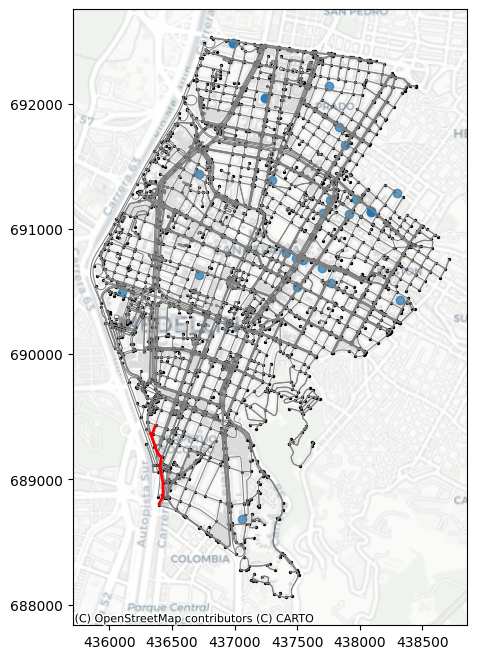

In [ ]:
from networkx.algorithms.structuralholes import local_constraint
###Instalar libreria
#!pip install osmnx

###importar libreria
import osmnx
from geopy.geocoders import Nominatim
import geopandas as gpd
from shapely import Point
import shapely.geometry
import matplotlib.pyplot
!pip install contextily
import contextily

##Definición área de estudio
PLACE_NAME="Centro,Medellin,Colombia"
graf=osmnx.graph_from_place(PLACE_NAME,network_type="all")

###Transformar datos a proyeccion
graf=osmnx.project_graph(graf)

#fig,ax=osmnx.plot_graph(graf)

nodos, ejes= osmnx.graph_to_gdfs(graf)
#nodos.head()
#ejes["highway"].value_counts()
#osmnx.basic_stats(graf)

###Definir puntos a trazar la ruta
geolocalizador= Nominatim(user_agent='OpenStreetMap Nominatim')
loc_o=geolocalizador.geocode('Carrera 44 #47-96, Medellin, Antioquia, 050016, Colombia')
loc_d=geolocalizador.geocode('Carrera 50 #47-26, Medellin, Antioquia, 050016, Colombia')
origen=gpd.GeoDataFrame(index=[0],crs='epsg:4236',geometry=[Point(loc_o.longitude,loc_o.latitude)]).to_crs(ejes.crs).at[0,"geometry"].centroid
destino=gpd.GeoDataFrame(index=[0],crs='epsg:4236',geometry=[Point(loc_d.longitude,loc_d.latitude)]).to_crs(ejes.crs).at[0,"geometry"].centroid

##Estraer nodos más cercanos
origen_node_id=osmnx.nearest_nodes(graf,origen.x,origen.y)
#origen_node_id
destino_node_id=osmnx.nearest_nodes(graf,destino.x,destino.y)
#destino_node_id


##Definir ruta
ruta=osmnx.shortest_path(graf,origen_node_id,destino_node_id)

##Obtener nodos
ruta_nodos=nodos.loc[ruta]

##Crear linea
ruta_linea=shapely.geometry.LineString(list(ruta_nodos.geometry.values))


##Crear geodataframe para graficar la ruta
ruta_geo=gpd.GeoDataFrame({"geometry":[ruta_linea],"osm_nodes":[ruta]},crs=ejes.crs)

ruta_geo['distancia']=ruta_geo.length
print(ruta_geo)

##Crear capa con los edificios
edificios=osmnx.geometries_from_place(PLACE_NAME,{"building":True}).to_crs(ejes.crs)

fig,ax=matplotlib.pyplot.subplots(figsize=(12,8))

ejes.plot(ax=ax,linewidth=0.75,color='gray')
nodos.plot(ax=ax,markersize=2,color='black')
ax=edificios.plot(ax=ax,facecolor='lightgray',alpha=0.7)
ax=ruta_geo.plot(ax=ax,linewidth=2,color='red')
contextily.add_basemap(ax,crs=ejes.crs,source=contextily.providers.CartoDB.Positron)
